<a href="https://colab.research.google.com/github/hmehryar/Hm.JetscapeMl/blob/ml5/jet_ml_pointnet/jet_ml_pointnet_classifier_all_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)# Point cloud classification with PointNet for Heavy Ion Collisions for diffrent dataset size and K-Folding

**Authors:** [Haydar Mehryar](https://github.com/hmehryar) <br>
**Date created:** 2023/12/01<br>
**Last modified:** 2020/12/20<br>
**Description:** Implementation of PointNet for heavy ion colllisions classifiction, based on the code from [David Griffiths](https://dgriffiths3.github.io)

In [1]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [4]:
# pip install --upgrade keras tensorflow

In [5]:
# loading libraries
print('Loading/Installing Package => Begin\n\n')
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import parse_parameters
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import install
# install("trimesh")
import os
from time import time
import glob
# import trimesh
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, History
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json


tf.random.set_seed(1234)
print('\nLoading/Installing Package => End\n\n')


Loading/Installing Package => Begin



Loading/Installing Package => End




In [6]:


print('\n########################################################################')
print('Checking the running platforms\n')

# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')





########################################################################
Checking the running platforms

Python version: 3.11.5
OS: Windows
OS version: 10
running on Colab: False
Dataset Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Results Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
Dataset Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
########################################################################



In [7]:


# Call the function and retrieve the tokenized parameters
tokenized_arguments, tokenized_values = parse_parameters()

# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

option --f not recognized
Tokenized Arguments:

Tokenized Values:
y_class_label_items: ['MMAT', 'MLBT']
alpha_s_items: [0.2, 0.3, 0.4]
q0_items: [1.5, 2.0, 2.5]


In [8]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
total_size=9*1200000


Building required params for the loading the dataset file


In [26]:
# Load the DataFrame from the saved file
def load_csv_into_dataframe(file_path):
  df_results = pd.read_csv(file_path, sep='\t')
  return df_results
#example usage
# df_results=load_csv_into_dataframe("/content/drive/MyDrive/Colab Notebooks/binary_classification_results_kfold_errorbar.txt")

In [29]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
n_epochs = 32
k_folds = 10 # You can adjust the number of folds

# defining dataset sizes and classifiers

# Sizes of datasets
dataset_sizes = [1000]
# dataset_sizes = [100000]
# dataset_sizes = [1000000]
# dataset_sizes = [1000, 10000]
#dataset_sizes = [1000, 10000,100000]
# dataset_sizes = [1000, 10000, 100000, 1000000]

print(simulation_directory_path)
simulation_path=f'{simulation_directory_path}jetml_pointnet_classification_eloss_{class_labels_str}'


D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\


In [35]:
simulation_path
simulation_directory_path

'D:\\Projects\\110_JetscapeMl\\hm.jetscapeml.data\\simulation_results\\'

In [51]:
result_kfold_name='jetml_pointnet_classification_eloss_MMAT_MLBT_results_kfold_1_100k.txt'
result_kfold_path=simulation_directory_path+result_kfold_name
df_results=load_csv_into_dataframe(result_kfold_path)

In [52]:
df_results

,Dataset Size,Classifier,Fold Number,Accuracy,Confusion Matrix,Train Time,Loss/Accuracy Plot Path,Best Model Path
0,1000,Pointnet,1,0.65500,[[57 44]\n [25 74]],5.794616,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
1,1000,Pointnet,2,0.63500,[[40 61]\n [12 87]],5.834462,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
2,1000,Pointnet,3,0.61000,[[58 43]\n [35 64]],5.831696,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
3,1000,Pointnet,4,0.55000,[[21 80]\n [10 89]],5.848229,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
4,1000,Pointnet,5,0.65500,[[43 58]\n [11 88]],5.905948,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
5,1000,Pointnet,6,0.60500,[[38 63]\n [16 83]],5.853792,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
6,1000,Pointnet,7,0.68500,[[72 29]\n [34 65]],5.820512,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
7,1000,Pointnet,8,0.63000,[[46 55]\n [19 80]],5.730660,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
8,1000,Pointnet,9,0.65500,[[63 38]\n [31 68]],5.516900,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...
9,1000,Pointnet,10,0.66000,[[57 44]\n [24 75]],5.370358,/content/drive/MyDrive/Projects/110_JetscapeMl...,/content/drive/MyDrive/Projects/110_JetscapeMl...


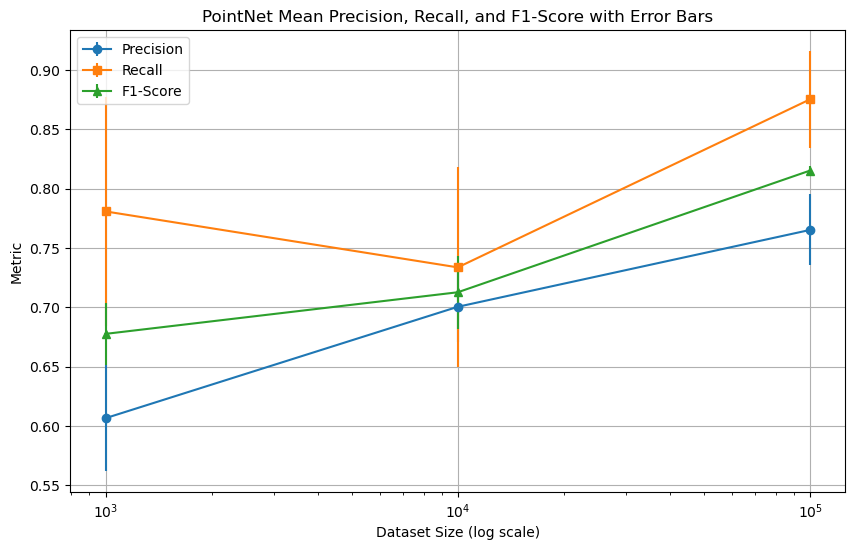

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics_and_plot(df):
    # Convert the 'Confusion Matrix' column from string to list
    # df['Confusion Matrix'] = df['Confusion Matrix'].apply()
    
    # Calculate precision, recall, and f1-score for each row
    precision = []
    recall = []
    f1_score = []
    for idx, row in df.iterrows():
        # tn, fp, fn, tp = row['Confusion Matrix'].ravel()
        tn, fp, fn, tp = row['Confusion Matrix']
         # Convert the confusion matrix from list of lists to numpy array
        # conf_matrix = np.array(row['Confusion Matrix'])
        # tn, fp, fn, tp = conf_matrix.ravel()  # Convert to 1D array to extract values
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))
    
    # Add precision, recall, and f1-score columns to the DataFrame
    df['Precision'] = precision
    df['Recall'] = recall
    df['F1-Score'] = f1_score
    
    # Calculate mean precision, recall, and f1-score for each dataset size
    mean_precision = df.groupby('Dataset Size')['Precision'].mean()
    mean_recall = df.groupby('Dataset Size')['Recall'].mean()
    mean_f1_score = df.groupby('Dataset Size')['F1-Score'].mean()
    
    # Plot mean error bar plot
    plt.figure(figsize=(10, 6))
    

    plt.errorbar(mean_precision.index, mean_precision, yerr=df.groupby('Dataset Size')['Precision'].std(), label='Precision', fmt='o', linestyle='-')
    plt.errorbar(mean_recall.index, mean_recall, yerr=df.groupby('Dataset Size')['Recall'].std(), label='Recall', fmt='s', linestyle='-')
    plt.errorbar(mean_f1_score.index, mean_f1_score, yerr=df.groupby('Dataset Size')['F1-Score'].std(), label='F1-Score', fmt='^', linestyle='-')


    

    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.grid(True,which='major',  axis='both')
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Metric')
    plt.title('PointNet Mean Precision, Recall, and F1-Score with Error Bars')
    plt.legend()
    
    # plt.tight_layout()
    plt.show()

# Assuming 'df' is the DataFrame containing your data
# Call the function to calculate metrics and plot
calculate_metrics_and_plot(df_results)


In [ ]:
# %%timeit -nl -rl
# start = time()
# with tf.device('/GPU:0'):
#     train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)
# gpu_train_time=time()-start
# print("gpu_train_time",gpu_train_time)

In [ ]:
# %%timeit -nl -rl
# start = time()
# with tf.device('/CPU:0'):
#     train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)
# gpu_train_time=time()-start
# print("cpu_train_time",gpu_train_time)